<h1> Correcting some bugs...</h1>

Seems like it doesn't make any difference though!!!

In [1]:
# own skrips
import helperfile as hf
# generalls libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

In [2]:
from uncertainties import unumpy as unp

In [3]:
def loss_flip_weighted(y_true, y_pred):
    bs = int(tf.size(y_true)/6) # batchsize
    ort_AL = 0.5 # cm
    E_AL = 2.5 # GeV
    weights = [tf.ones(bs)*ort_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*E_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*E_AL]
    sq = k.square((y_true - y_pred) / tf.transpose(weights))
    mse = k.sum(sq, axis=1)
    
    y_pred_flipped = tf.roll(y_pred, 3, axis=1)
    sq_flipped = k.square((y_true - y_pred_flipped) / tf.transpose(weights))
    mse_flipped = k.sum(sq_flipped, axis=1)
    vec = tf.stack([mse, mse_flipped], axis=1)
    loss = k.min(vec, axis=1)
    return loss

In [4]:
rootfile = uproot.open('./stage4_clusters_minDist2cm.root')
ipd = hf.InputData_2photon(rootfile, min_dist=4, sort_cond='none')
ipd.form_cluster()
ipd.train_test_split()

Initialized object
Cutted  938261  clusters due to photon pair with distance smaller than  4  cm.
Start shaping clusters in a  (9, 9)  grid...
Shaping the clusters took  247.16574001312256 s
Splitted data into training and test set!
Prepared 'veri_truth' data
Prepared 'veri_fit' data (Lednev fit from coral)


In [5]:
def flip_output_weights(output):
    '''out is output of NN'''
    ort_AL = 0.5 # cm
    E_AL = 2.5 # GeV
    weights = np.ones((len(output), 6)) * np.array([ort_AL, ort_AL, E_AL, ort_AL, ort_AL, E_AL])
    #out_w = out/weights
    output_flipped = np.roll(output, 3, axis=1)
    mse = np.sum(np.square(output/weights-ipd.veri_truth/weights), axis=1)
    mse_flipped = np.sum(np.square(output_flipped/weights-ipd.veri_truth/weights), axis=1)
    ind_flip = np.where(mse_flipped<mse)
    output[ind_flip] = np.roll(output[ind_flip], 3, axis=1)
    return output

In [6]:
model= keras.models.load_model('models/model_st4_weighted_loss', custom_objects={'loss_flip_weighted': loss_flip_weighted})
output = model.predict(ipd.clusters_v)
output_= flip_output_weights(output)
ev = hf.Evaluation_2photon(ipd, output)

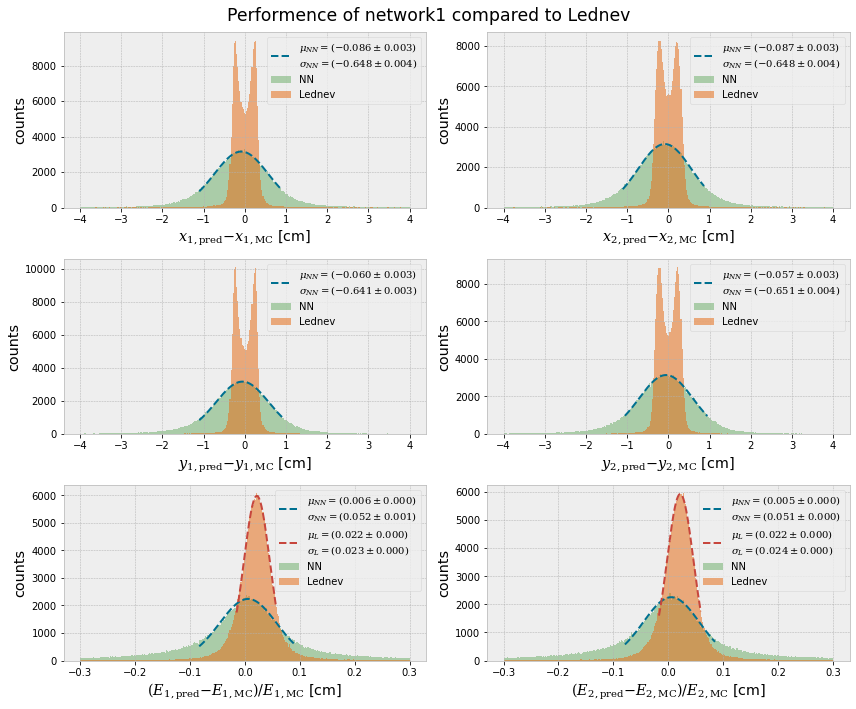

In [7]:
ev_fit_v_Lednev = ev.show_hist_NN_withLednev()

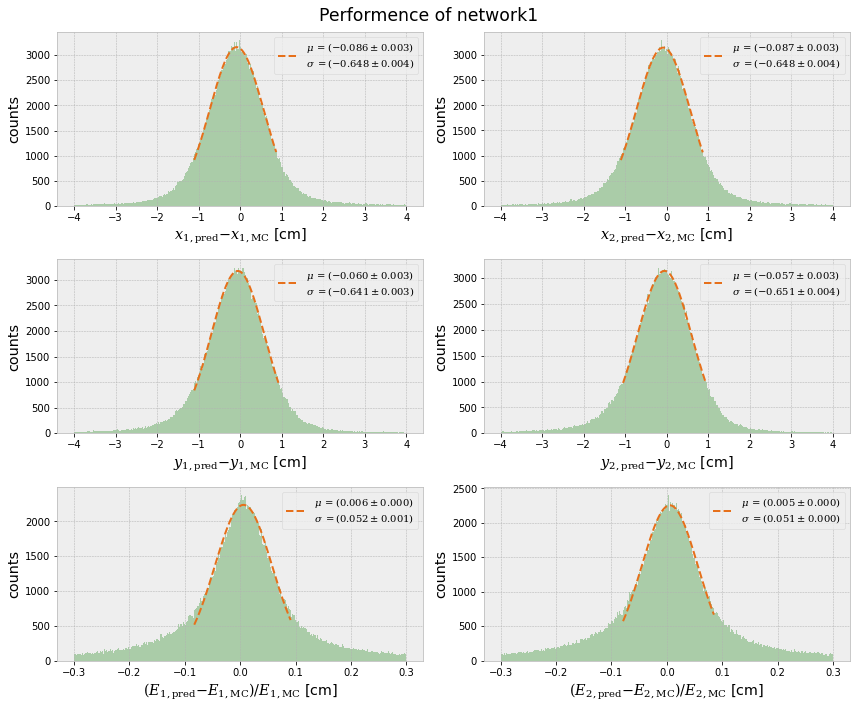

In [8]:
ev_fit = ev.show_hist_NN()

In [9]:
print(ev_fit)

[-0.08626265440531648+/-0.002986157772879947
 -0.6482720816823591+/-0.004064748689572665
 -0.08680448798249259+/-0.00284393359789691
 -0.6477408090587925+/-0.0038770606316675697
 -0.060075662787641676+/-0.0025515090926545945
 -0.6411167818860346+/-0.0034027251140570317
 -0.05658929255991423+/-0.0026355119103090062
 -0.6512635082970494+/-0.0035810675480148287
 0.005885446425814562+/-0.00039901574904219374
 0.05185529150674436+/-0.0005094558382643583
 0.0054263200502114904+/-0.0003399592288869704
 0.05095189516328751+/-0.0004448617108874692]


**to sum up:** Ok... doesn't seem like this makes a significant difference!

<h2> Is adding the position due to angles useful? </h2>

Let's look at this angles...

In [10]:
theta_x1_v = np.arccos(ipd.momentum_v.T[0]/ (np.linalg.norm(ipd.momentum_v.T[:3].T, axis=1)))
theta_y1_v = np.arccos(ipd.momentum_v.T[1]/ (np.linalg.norm(ipd.momentum_v.T[:3].T, axis=1)))
theta_z1_v = np.arccos(ipd.momentum_v.T[2]/ (np.linalg.norm(ipd.momentum_v.T[:3].T, axis=1)))
theta_x1_t = np.arccos(ipd.momentum_t.T[0]/ (np.linalg.norm(ipd.momentum_t.T[:3].T, axis=1)))
theta_y1_t = np.arccos(ipd.momentum_t.T[1]/ (np.linalg.norm(ipd.momentum_t.T[:3].T, axis=1)))
theta_z1_t = np.arccos(ipd.momentum_t.T[2]/ (np.linalg.norm(ipd.momentum_t.T[:3].T, axis=1)))

theta_x2_v = np.arccos(ipd.momentum_v.T[0+3]/ (np.linalg.norm(ipd.momentum_v.T[3:].T, axis=1)))
theta_y2_v = np.arccos(ipd.momentum_v.T[1+3]/ (np.linalg.norm(ipd.momentum_v.T[3:].T, axis=1)))
theta_z2_v = np.arccos(ipd.momentum_v.T[2+3]/ (np.linalg.norm(ipd.momentum_v.T[3:].T, axis=1)))
theta_x2_t = np.arccos(ipd.momentum_t.T[0+3]/ (np.linalg.norm(ipd.momentum_t.T[3:].T, axis=1)))
theta_y2_t = np.arccos(ipd.momentum_t.T[1+3]/ (np.linalg.norm(ipd.momentum_t.T[3:].T, axis=1)))
theta_z2_t = np.arccos(ipd.momentum_t.T[2+3]/ (np.linalg.norm(ipd.momentum_t.T[3:].T, axis=1)))

Wie ist denn die Winkelverteilung eigentlich?

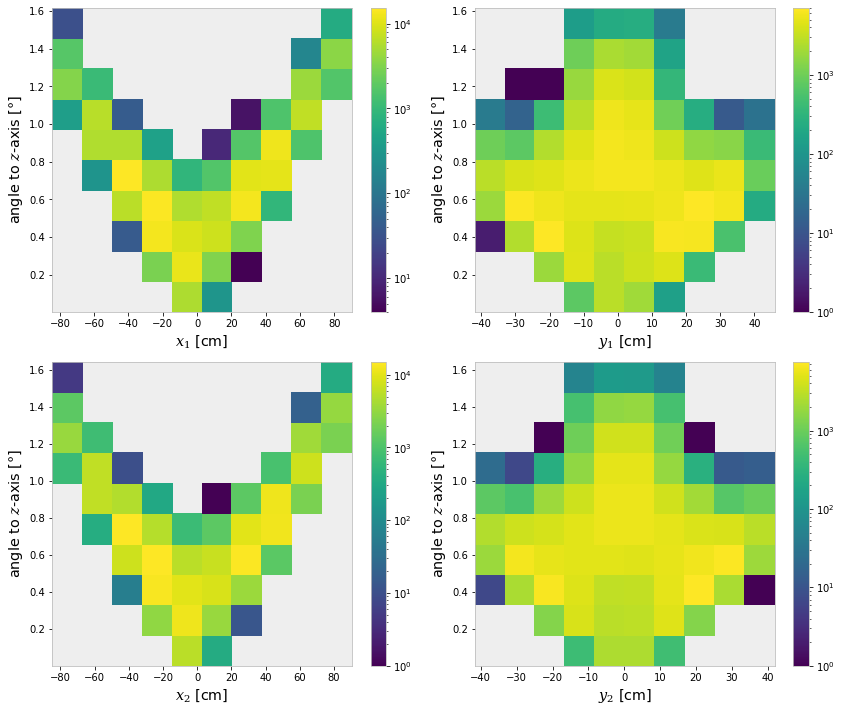

In [11]:
plt.subplot(2,2,1)
plt.hist2d(ipd.x_truth_veri.T[0].T, theta_z1_v*360/(2*np.pi), norm=LogNorm())
plt.colorbar()
plt.ylabel("angle to $z$-axis [$\degree$]")
plt.xlabel("$x_1$ [cm]")

plt.subplot(2,2,2)
plt.hist2d(ipd.y_truth_veri.T[0].T, theta_z1_v*360/(2*np.pi), norm=LogNorm())
plt.colorbar()
plt.ylabel("angle to $z$-axis [$\degree$]")
plt.xlabel("$y_1$ [cm]")

plt.subplot(2,2,3)
plt.hist2d(ipd.x_truth_veri.T[1].T, theta_z2_v*360/(2*np.pi), norm=LogNorm())
plt.colorbar()
plt.ylabel("angle to $z$-axis [$\degree$]")
plt.xlabel("$x_2$ [cm]")

plt.subplot(2,2,4)
plt.hist2d(ipd.y_truth_veri.T[1].T, theta_z2_v*360/(2*np.pi), norm=LogNorm())
plt.colorbar()
plt.ylabel("angle to $z$-axis [$\degree$]")
plt.xlabel("$y_2$ [cm]")

plt.tight_layout()
plt.show()

Achtung! Oben ist nicht normiert!

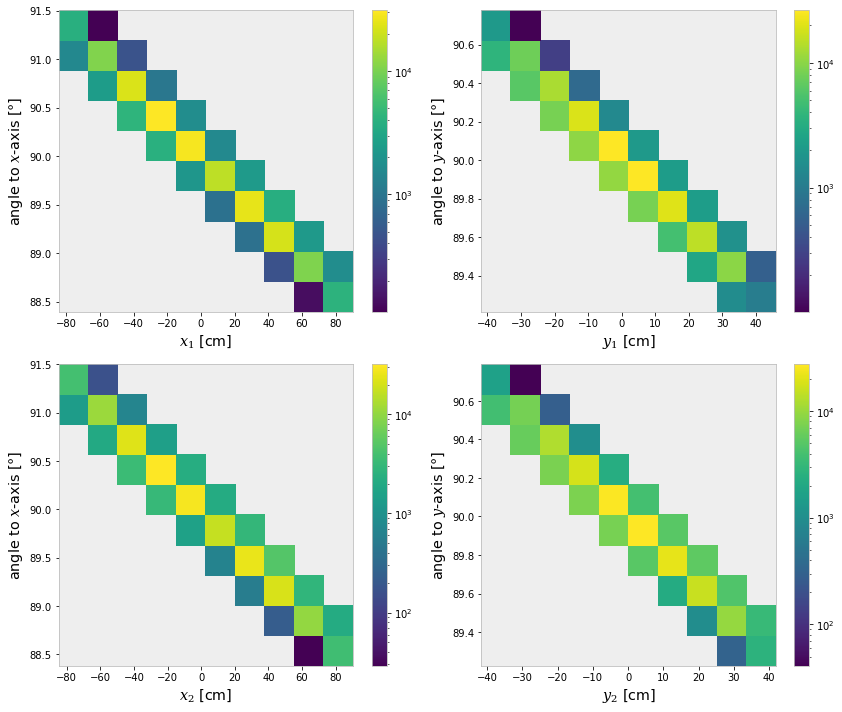

In [12]:
plt.subplot(2,2,1)
plt.hist2d(ipd.x_truth_veri.T[0].T, theta_x1_v*360/(2*np.pi), norm=LogNorm())
plt.colorbar()
plt.ylabel("angle to $x$-axis [$\degree$]")
plt.xlabel("$x_1$ [cm]")

plt.subplot(2,2,2)
plt.hist2d(ipd.y_truth_veri.T[0].T, theta_y1_v*360/(2*np.pi), norm=LogNorm())
plt.colorbar()
plt.ylabel("angle to $y$-axis [$\degree$]")
plt.xlabel("$y_1$ [cm]")

plt.subplot(2,2,3)
plt.hist2d(ipd.x_truth_veri.T[1].T, theta_x2_v*360/(2*np.pi), norm=LogNorm())
plt.colorbar()
plt.ylabel("angle to $x$-axis [$\degree$]")
plt.xlabel("$x_2$ [cm]")

plt.subplot(2,2,4)
plt.hist2d(ipd.y_truth_veri.T[1].T, theta_y2_v*360/(2*np.pi), norm=LogNorm())
plt.colorbar()
plt.ylabel("angle to $y$-axis [$\degree$]")
plt.xlabel("$y_2$ [cm]")

plt.tight_layout()
plt.show()

-> Ok! It would make sense to give the total position as an input as the position and the angles correlate with each other. That the network has troubles with larger angles can one already see in stage 3. It was solved by giving the total position as an input as well.

check if bigger angles are learned worse..?

In [13]:
print(ev_fit)

[-0.08626265440531648+/-0.002986157772879947
 -0.6482720816823591+/-0.004064748689572665
 -0.08680448798249259+/-0.00284393359789691
 -0.6477408090587925+/-0.0038770606316675697
 -0.060075662787641676+/-0.0025515090926545945
 -0.6411167818860346+/-0.0034027251140570317
 -0.05658929255991423+/-0.0026355119103090062
 -0.6512635082970494+/-0.0035810675480148287
 0.005885446425814562+/-0.00039901574904219374
 0.05185529150674436+/-0.0005094558382643583
 0.0054263200502114904+/-0.0003399592288869704
 0.05095189516328751+/-0.0004448617108874692]


In [14]:
sig_x1 = unp.nominal_values(ev_fit[1])
sig_x2 = unp.nominal_values(ev_fit[3])
sig_y1 = unp.nominal_values(ev_fit[5])
sig_y2 = unp.nominal_values(ev_fit[7])

In [16]:
def loss_flip_weighted(y_true, y_pred):
    bs = int(tf.size(y_true)/6) # batchsize
    ort_AL = 0.5 # cm
    E_AL = 2.5 # GeV
    weights = [tf.ones(bs)*ort_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*E_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*E_AL]
    sq = k.square((y_true - y_pred) / tf.transpose(weights))
    mse = k.sum(sq, axis=1)
    
    y_pred_flipped = tf.roll(y_pred, 3, axis=1)
    sq_flipped = k.square((y_true - y_pred_flipped) / tf.transpose(weights))
    mse_flipped = k.sum(sq_flipped, axis=1)
    vec = tf.stack([mse, mse_flipped], axis=1)
    loss = k.min(vec, axis=1)
    return loss
    
def flip_output_weights(output):
    '''output is output of NN'''
    ort_AL = 0.5 # cm
    E_AL = 2.5 # GeV
    weights = np.ones((len(output), 6)) * np.array([ort_AL, ort_AL, E_AL, ort_AL, ort_AL, E_AL])
    #out_w = out/weights
    output_flipped = np.roll(output, 3, axis=1)
    mse = np.sum(np.square(output/weights-ipd.veri_truth/weights), axis=1)
    mse_flipped = np.sum(np.square(output_flipped/weights-ipd.veri_truth/weights), axis=1)
    ind_flip = np.where(mse_flipped<mse)
    output[ind_flip] = np.roll(output[ind_flip], 3, axis=1)
    return output

In [17]:
# add total position
ipd.clusters_t = np.append(ipd.clusters_t, ipd.coord_t, axis=1)
ipd.clusters_v = np.append(ipd.clusters_v, ipd.coord_v, axis=1)

In [18]:
model1 = keras.models.load_model('models/model_st4_total_position', custom_objects={'loss_flip_weighted': loss_flip_weighted})
output1 = model1.predict(ipd.clusters_v)
output1_= flip_output_weights(output1)
ev1 = hf.Evaluation_2photon(ipd, output1)

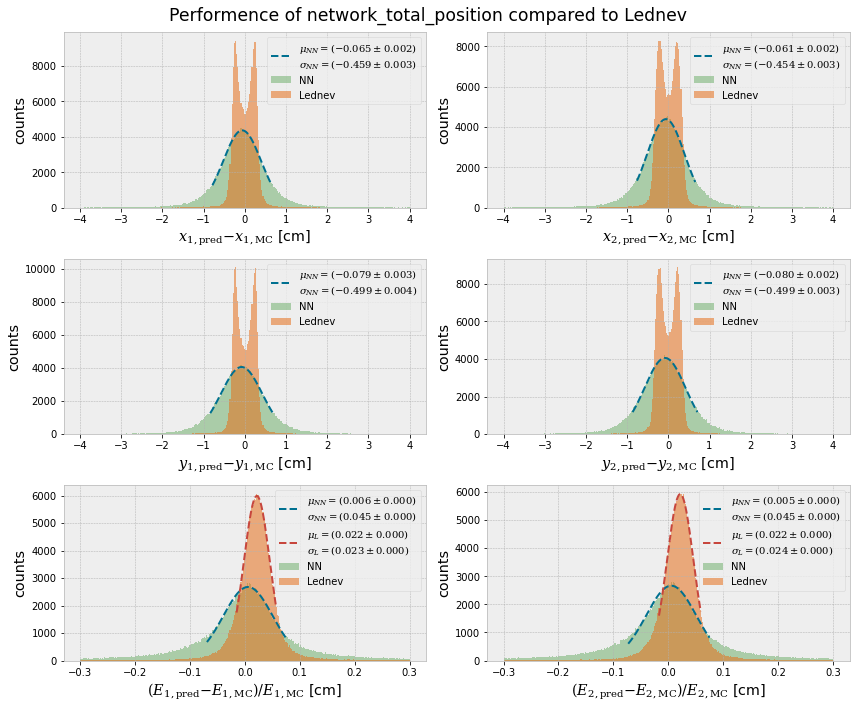

In [19]:
ev1_fit_v_Lednev = ev1.show_hist_NN_withLednev(figsave=(False, "network_total_position"))